In [1]:
!pip install "numpy<2.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 106.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires jupyter-server==2.14.0, but you have jupyter-server 2.12.5 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
jaxlib 0.7.2 req

In [2]:
%pip install ultralytics
import ultralytics
from ultralytics import YOLO
import os
import yaml
import cv2
import matplotlib.pyplot as plt

ultralytics.checks()

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6632.9/8062.4 GB disk)


In [3]:
!pip uninstall -y ray

Found existing installation: ray 2.52.1
Uninstalling ray-2.52.1:
  Successfully uninstalled ray-2.52.1


In [4]:

INPUT_DIR = '/kaggle/input/deep-pcb' 

data_config = {
    'path': INPUT_DIR,
    'train': 'images/train',
    'val': 'images/val',     
    
 
    'names': {
        0: 'missing_hole',
        1: 'mouse_bite',
        2: 'open_circuit',
        3: 'short',
        4: 'spur',
        5: 'spurious_copper'
    }
}

with open('/kaggle/working/data.yaml', 'w') as f:
    yaml.dump(data_config, f)

print("data.yaml created successfully!")

data.yaml created successfully!


In [5]:
import shutil
model = YOLO('yolov8n.yaml')  

results = model.train(
    data='/kaggle/working/data.yaml', 
    epochs=100,                       
    imgsz=640,                        
    batch=16,                         
    name='pcb_scratch_model',          
    project='/kaggle/working/runs',    
    exist_ok=True,                     
    optimizer='AdamW',                 
    lr0=0.01                           
)

print("Training from scratch completed!")
shutil.copy('/kaggle/working/runs/pcb_scratch_model/weights/best.pt', '/kaggle/working/my_final_pcb_model.pt')
print("Training from scratch completed and model saved as 'my_final_pcb_model.pt'!")

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=pcb_scratch_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, plots=

ImportError: cannot import name '_center' from 'numpy._core.umath' (/usr/local/lib/python3.12/dist-packages/numpy/_core/umath.py)

In [6]:
import shutil
import os

source_path = '/kaggle/working/runs/pcb_scratch_model/weights/best.pt'
destination_path = '/kaggle/working/my_final_pcb_model.pt'

if os.path.exists(source_path):
    shutil.copy(source_path, destination_path)
    print(f" Success! Model copied to: {destination_path}")
    print(f"Model Size: {os.path.getsize(destination_path) / 1024 / 1024:.2f} MB")
else:
    print(f" Error: Could not find model at {source_path}")

 Success! Model copied to: /kaggle/working/my_final_pcb_model.pt
Model Size: 5.97 MB


In [7]:
def analyze_pcb_defect(image_path, model_path='/kaggle/working/runs/pcb_scratch_model/weights/best.pt'):
    """
    Analyzes a PCB image using the model trained from scratch.
    Satisfies Task 2 Requirements: Detect, Localize, Classify, Coordinate Output.
    """
    
    if not os.path.exists(model_path):
        print(f"Error: Model not found at {model_path}. Did training finish?")
        return None, []

    model = YOLO(model_path)
    
    results = model.predict(image_path, conf=0.20, save=False) 
    result = results[0]
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    detected_defects = []

    print(f"\n--- INSPECTION REPORT: {os.path.basename(image_path)} ---")
    
    for box in result.boxes:
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        center_x = int((x1 + x2) / 2)
        center_y = int((y1 + y2) / 2)
        
        cls_id = int(box.cls)
        class_name = result.names[cls_id]
        conf = float(box.conf)
        
        if class_name in ['missing_hole', 'short', 'open_circuit']:
            severity = "CRITICAL"
        elif conf > 0.7:
            severity = "HIGH"
        else:
            severity = "MODERATE"
            
        detected_defects.append({
            "type": class_name,
            "center": (center_x, center_y),
            "severity": severity,
            "confidence": conf
        })
        
        print(f"Defect: {class_name:<15} | Center: ({center_x:>4}, {center_y:>4}) | Severity: {severity:<8} | Conf: {conf:.2f}")

    return result.plot(), detected_defects

test_img = '/kaggle/input/deep-pcb/deep-pcb/images/val/1.jpg' 

if os.path.exists(test_img):
    annotated, data = analyze_pcb_defect(test_img)
    if annotated is not None:
        plt.figure(figsize=(10, 10))
        plt.imshow(annotated)
        plt.axis('off')
        plt.title("Defect Detection (Trained from Scratch)")
        plt.show()

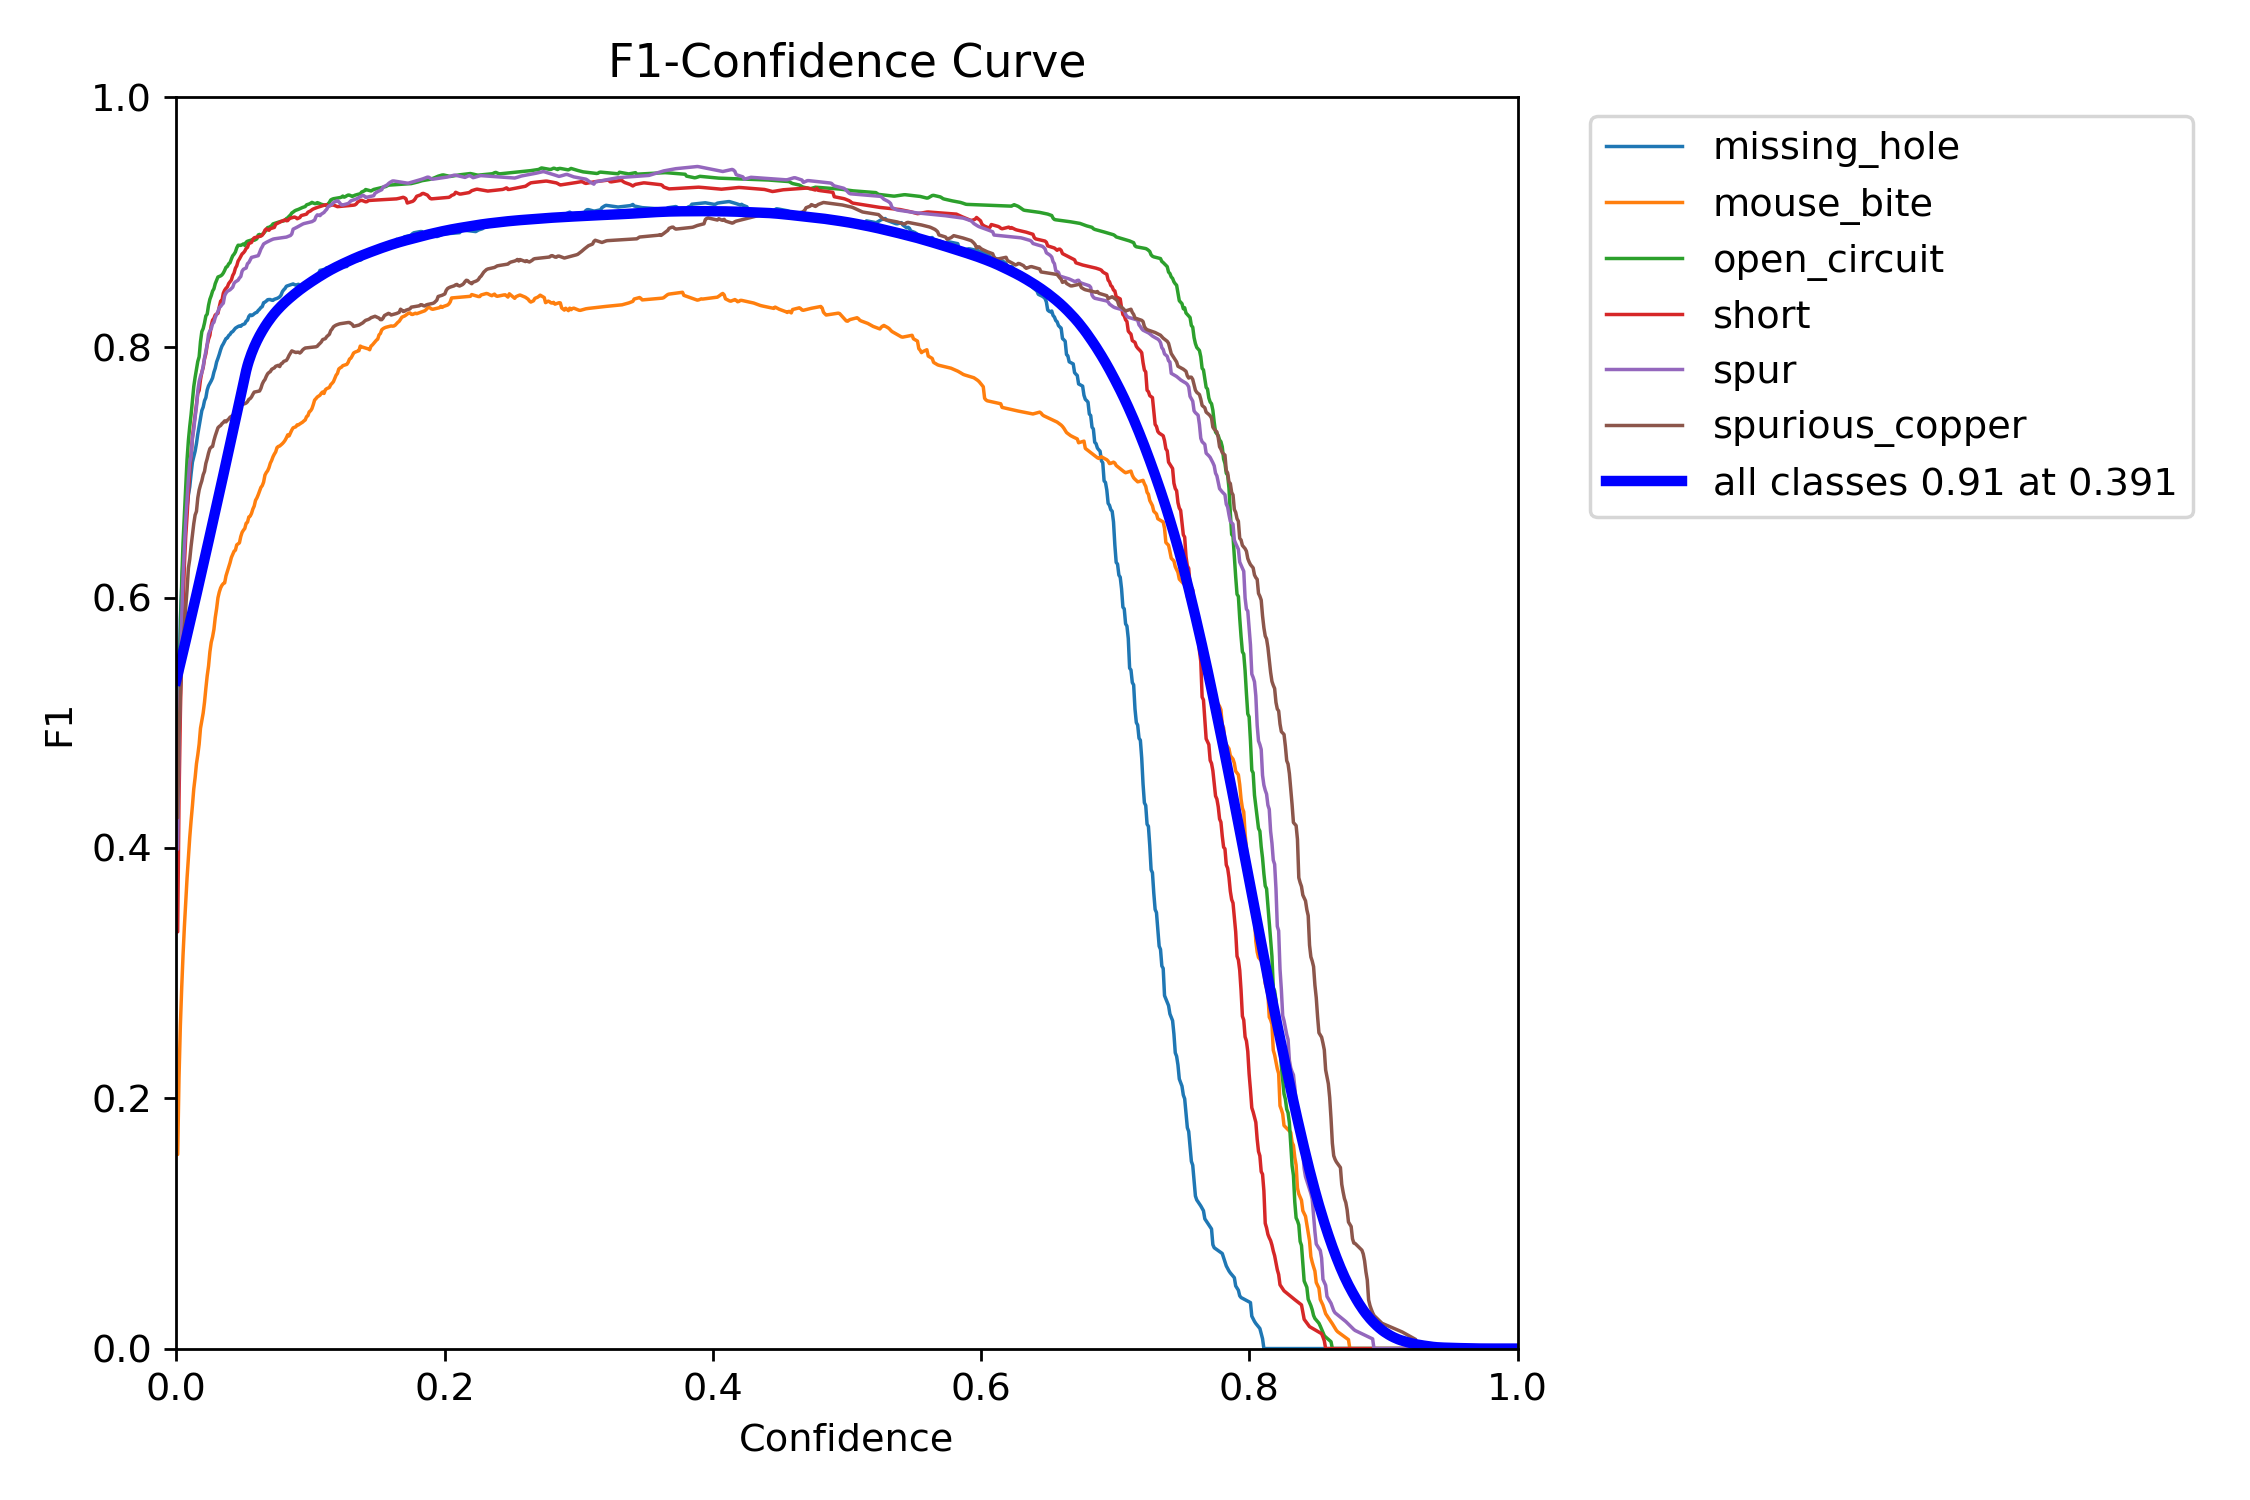

In [10]:
from IPython.display import Image
Image(filename='/kaggle/working/runs/pcb_scratch_model/BoxF1_curve.png')

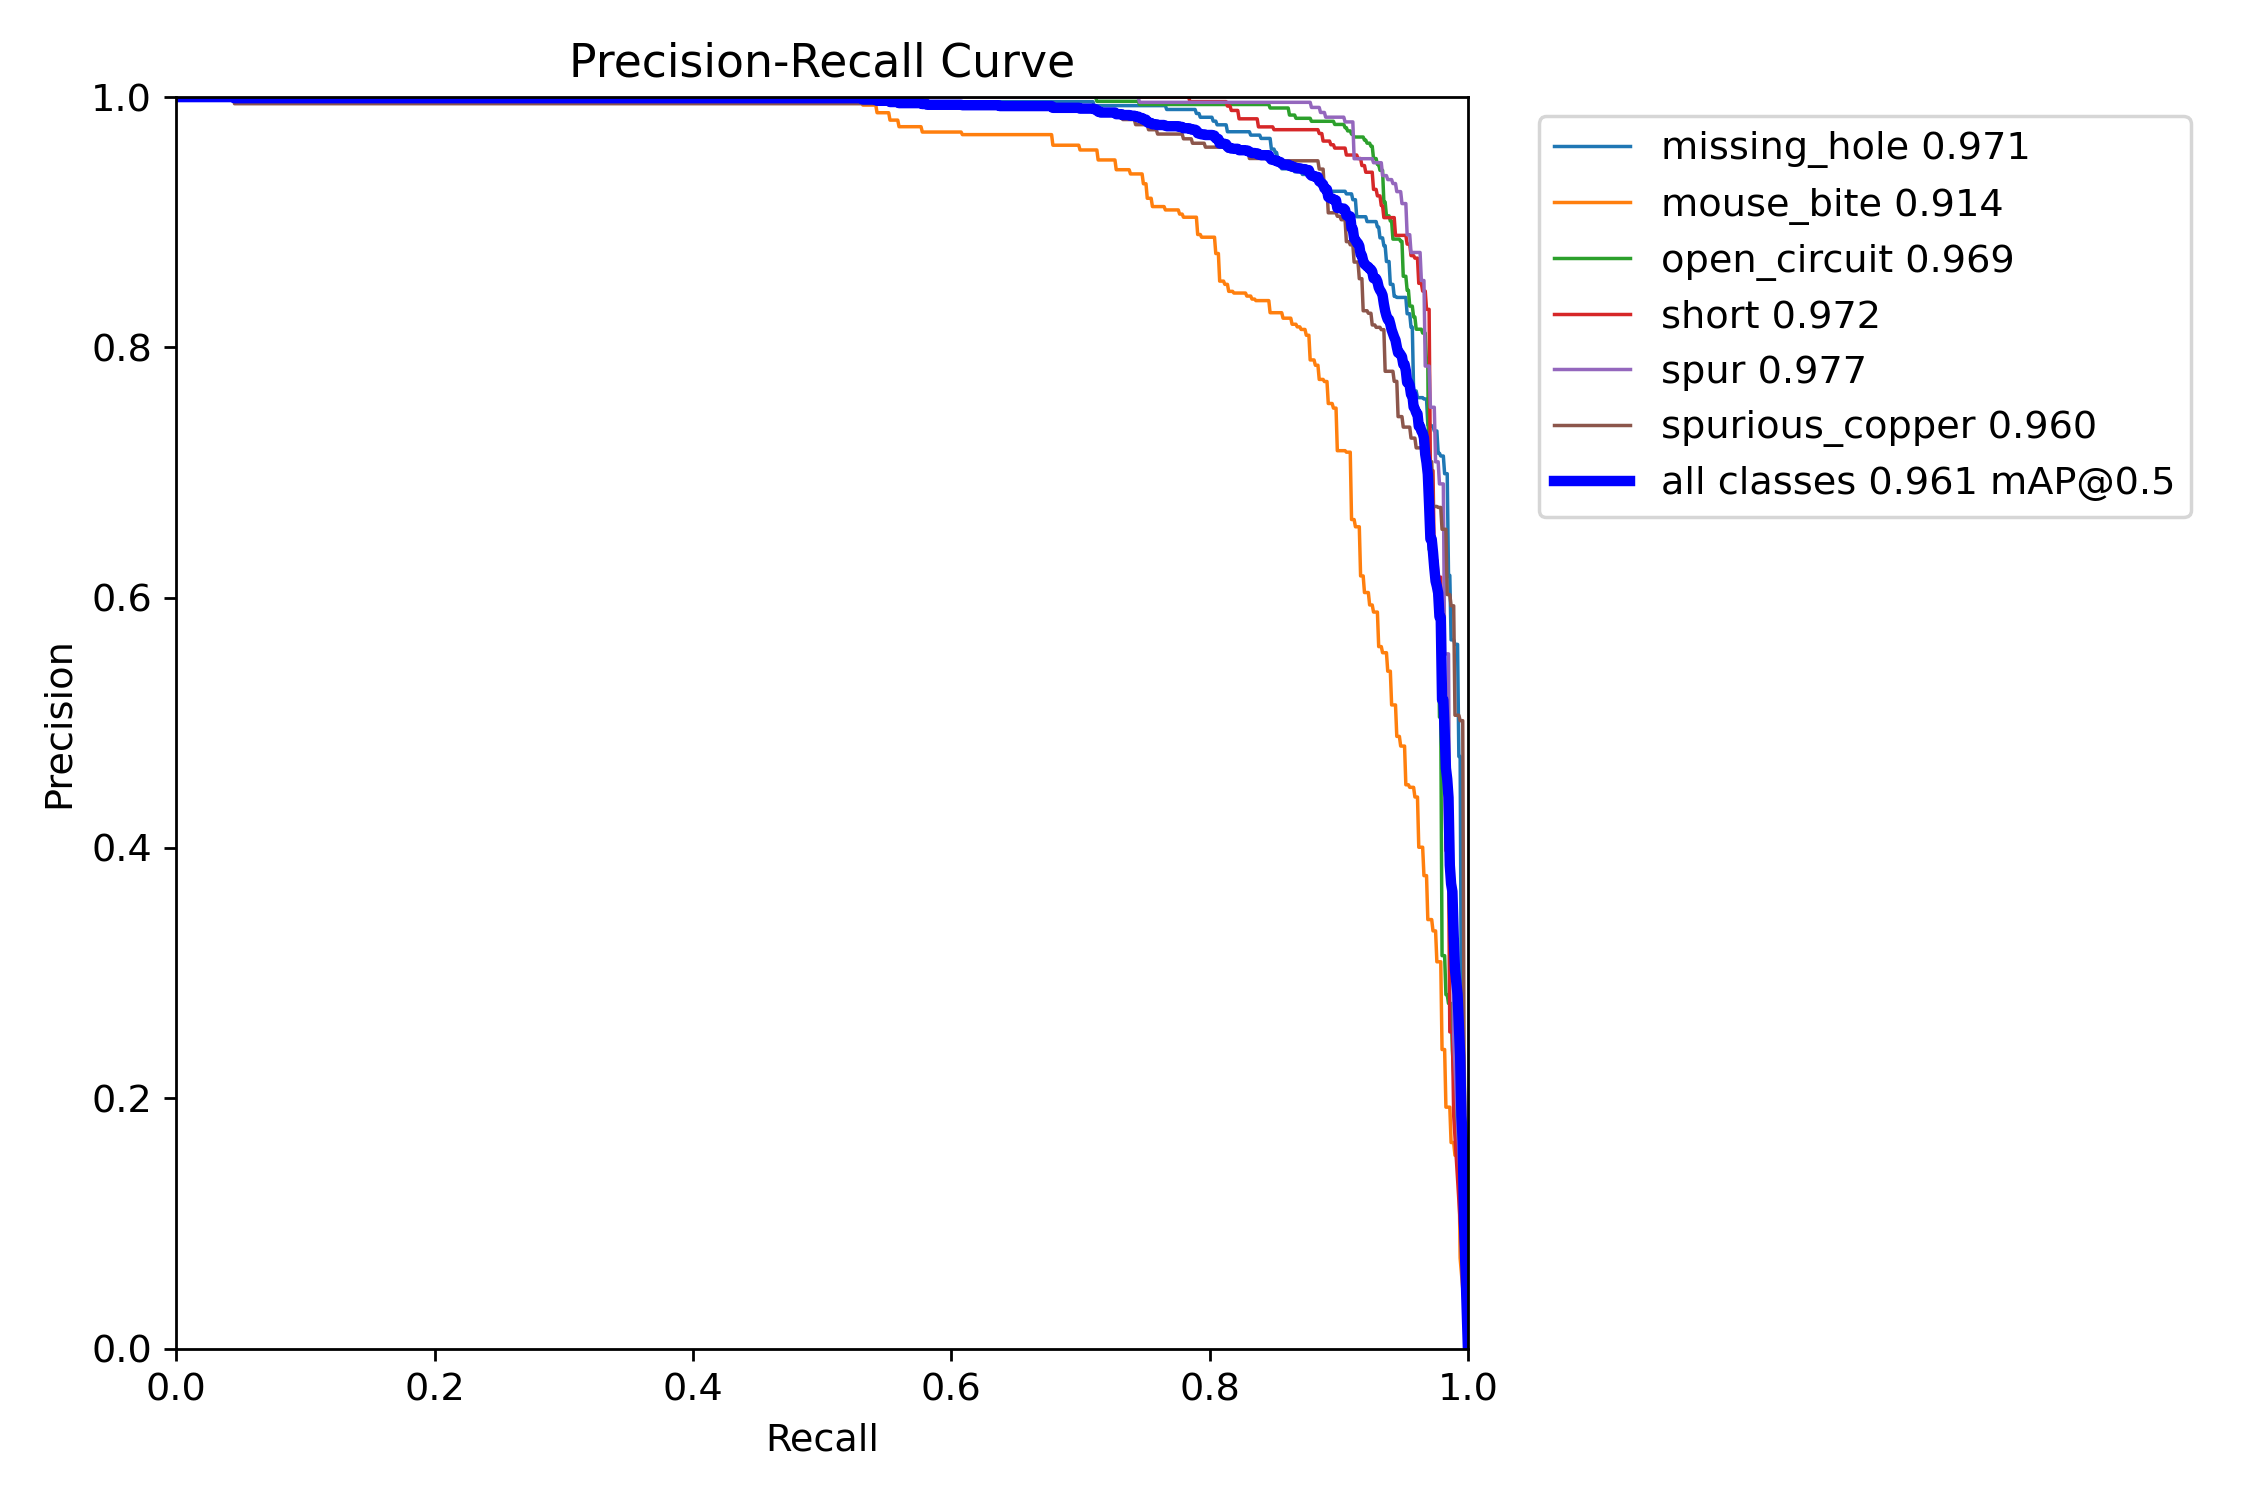

In [11]:
from IPython.display import Image
Image(filename='/kaggle/working/runs/pcb_scratch_model/BoxPR_curve.png')

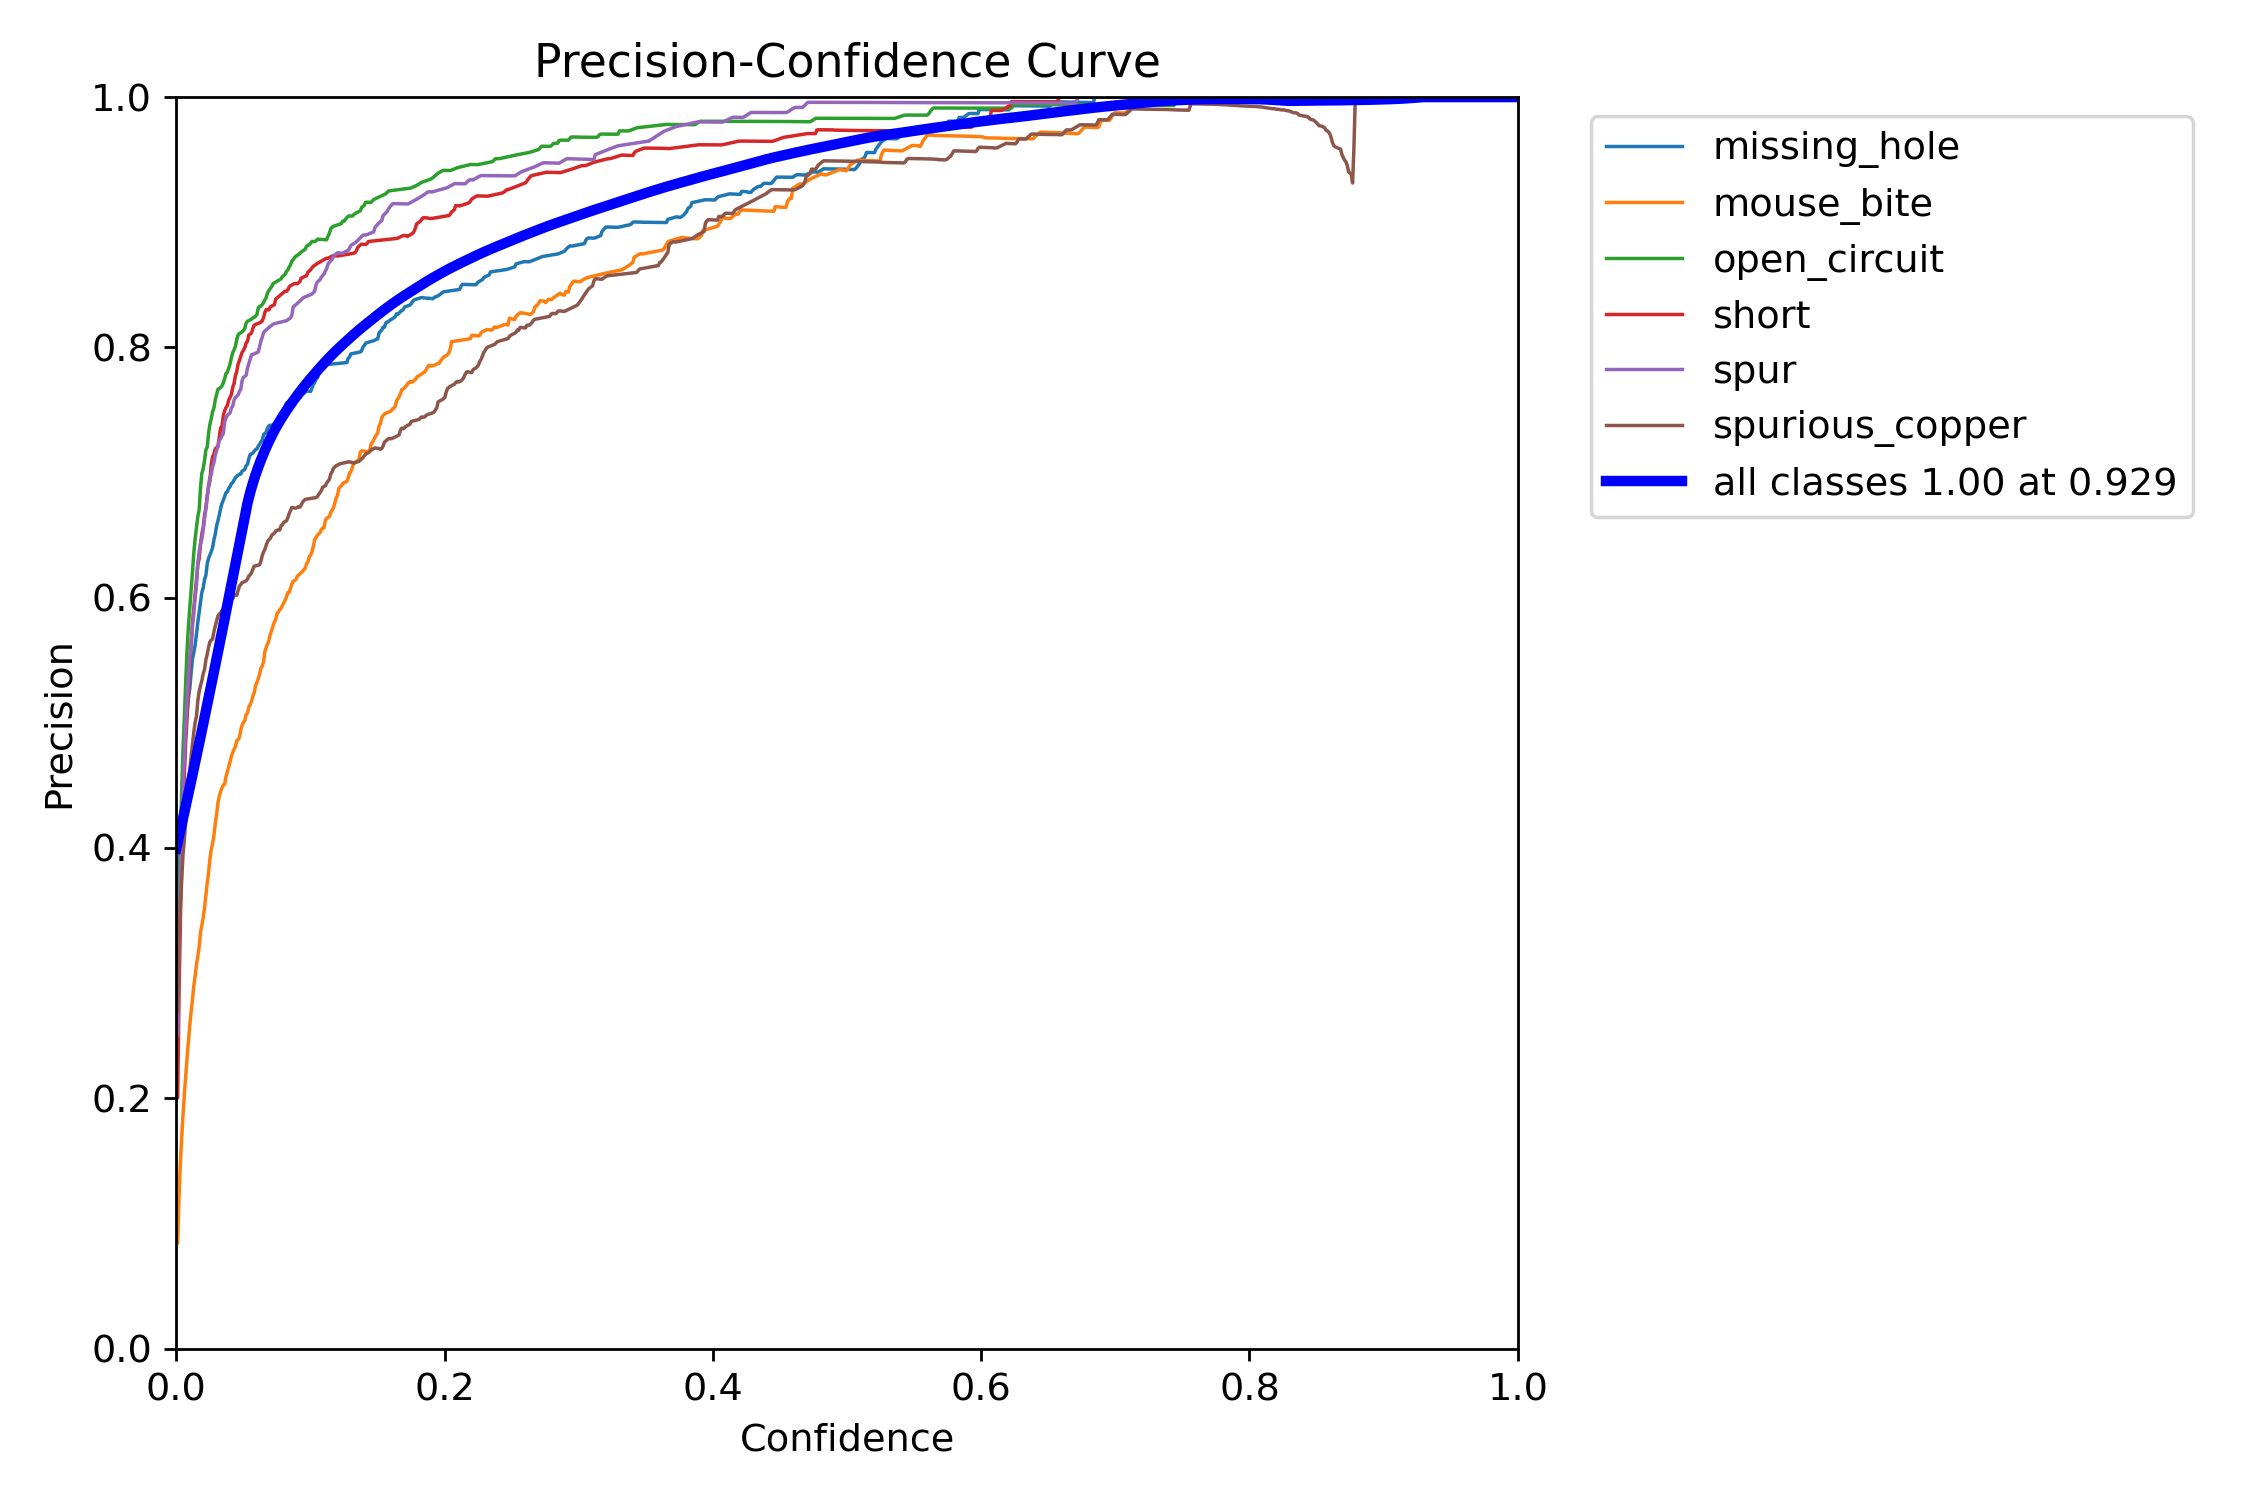

In [12]:
from IPython.display import Image
Image(filename='/kaggle/working/runs/pcb_scratch_model/BoxP_curve.png')

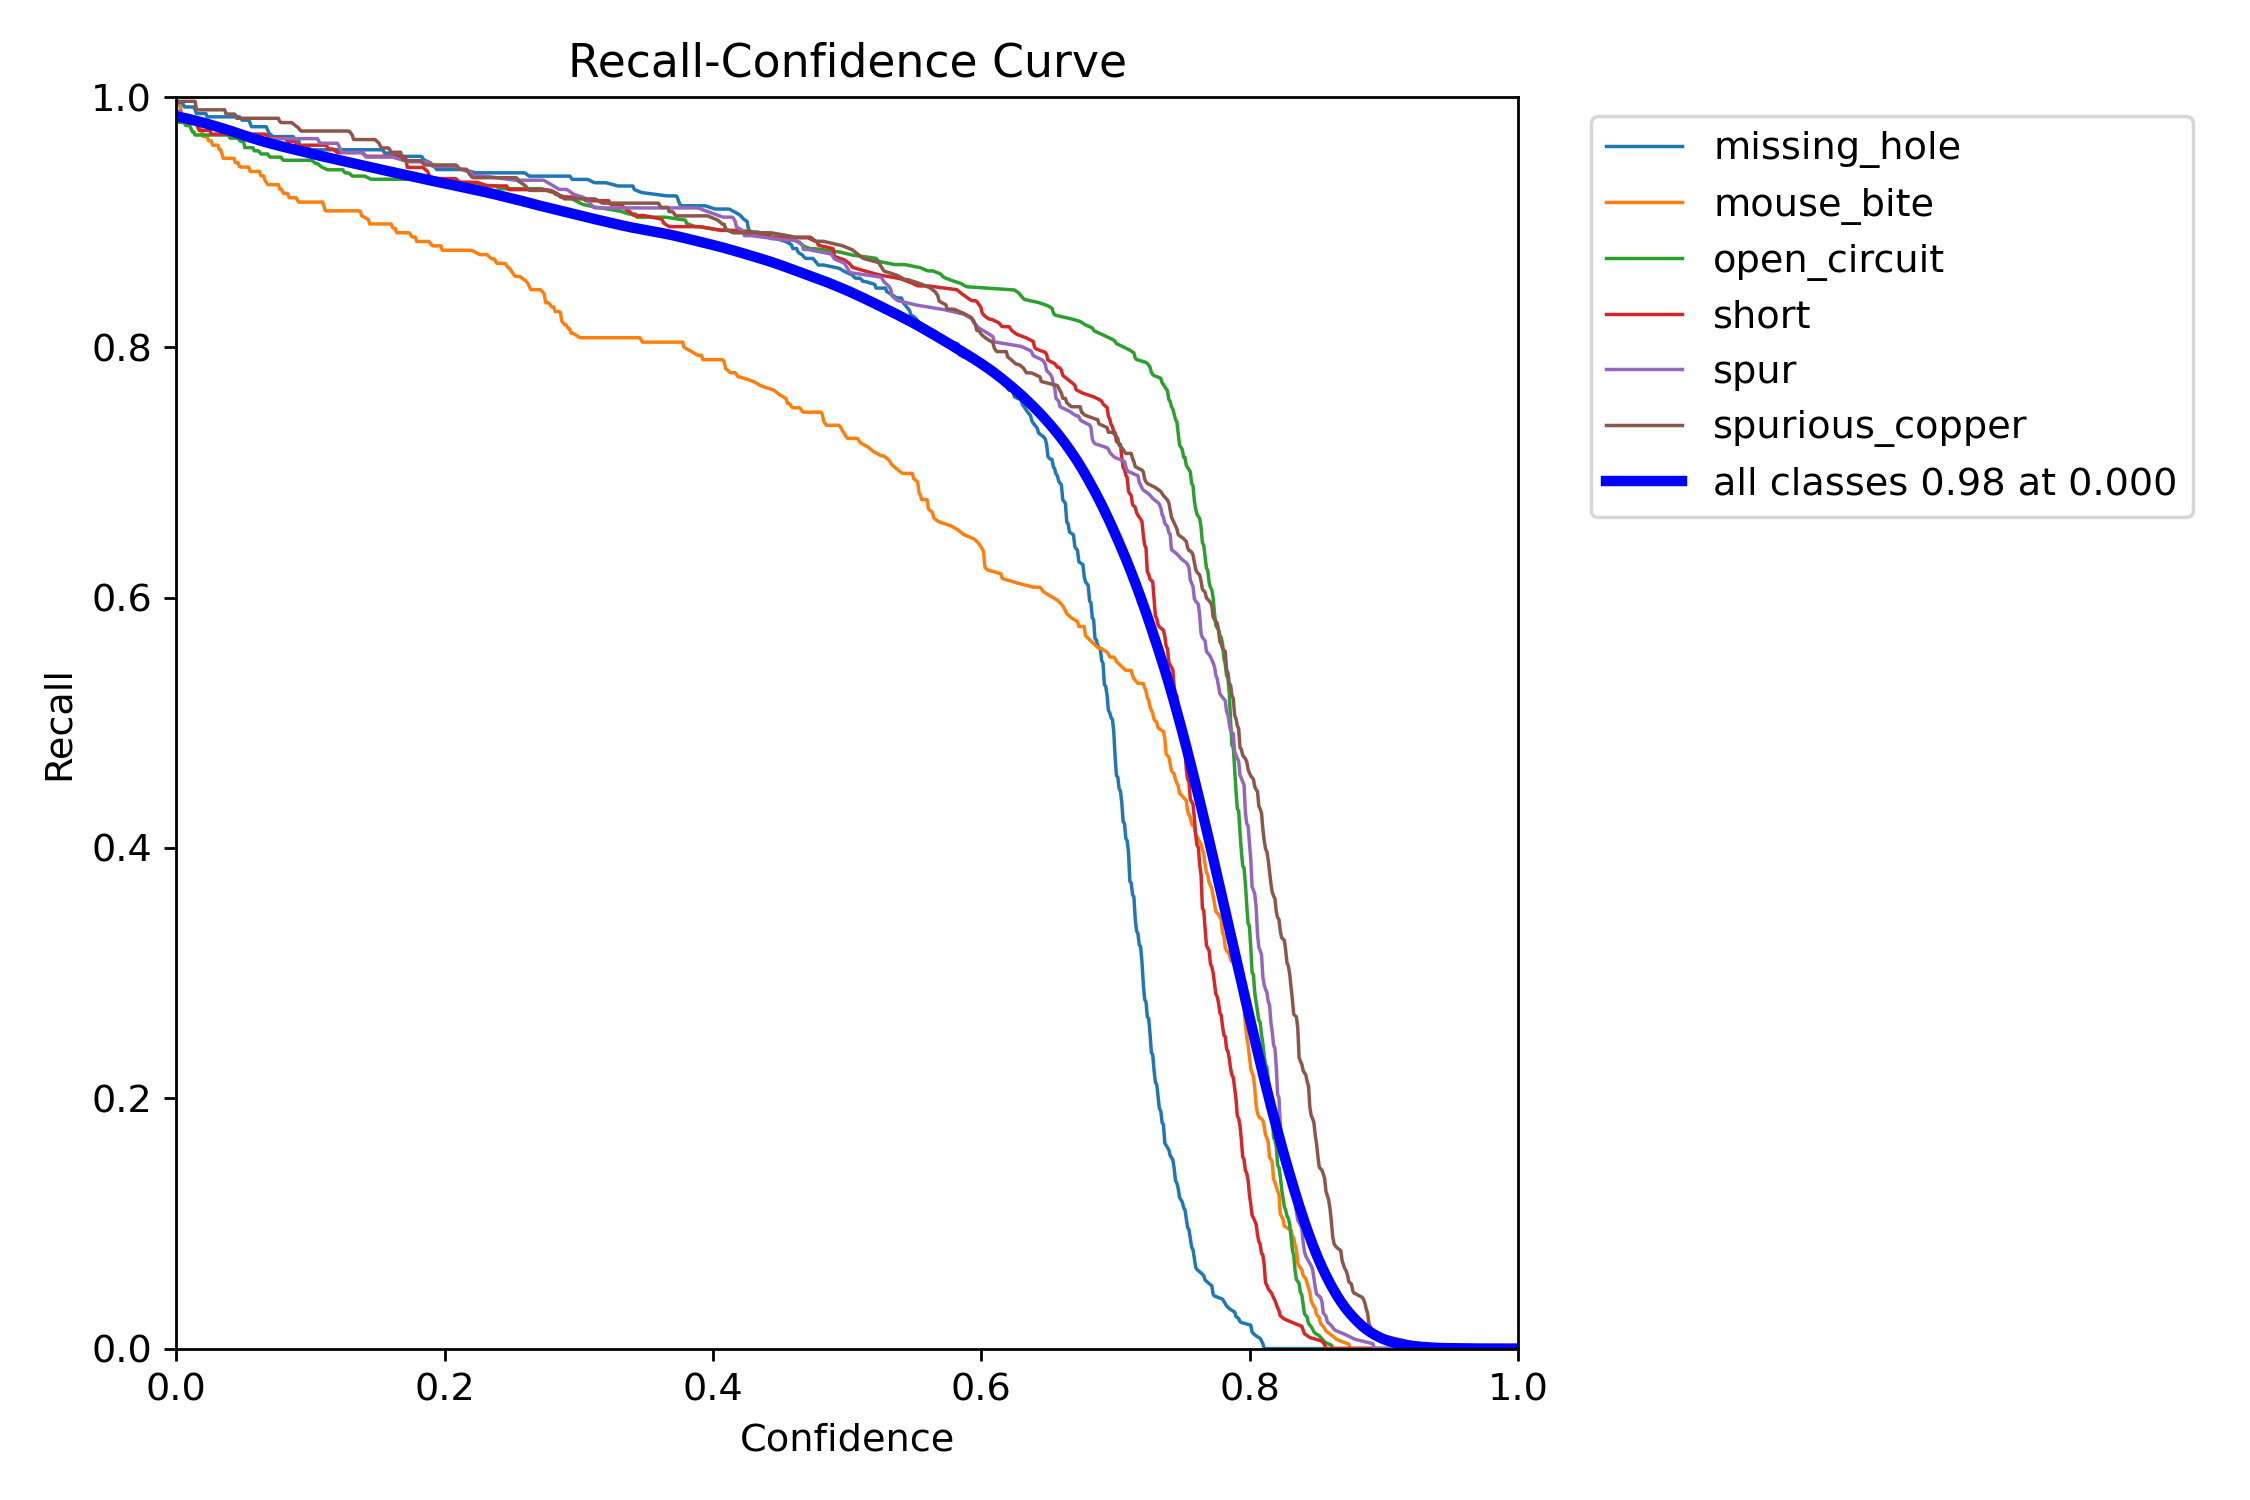

In [14]:
from IPython.display import Image
Image(filename='/kaggle/working/runs/pcb_scratch_model/BoxR_curve.png')

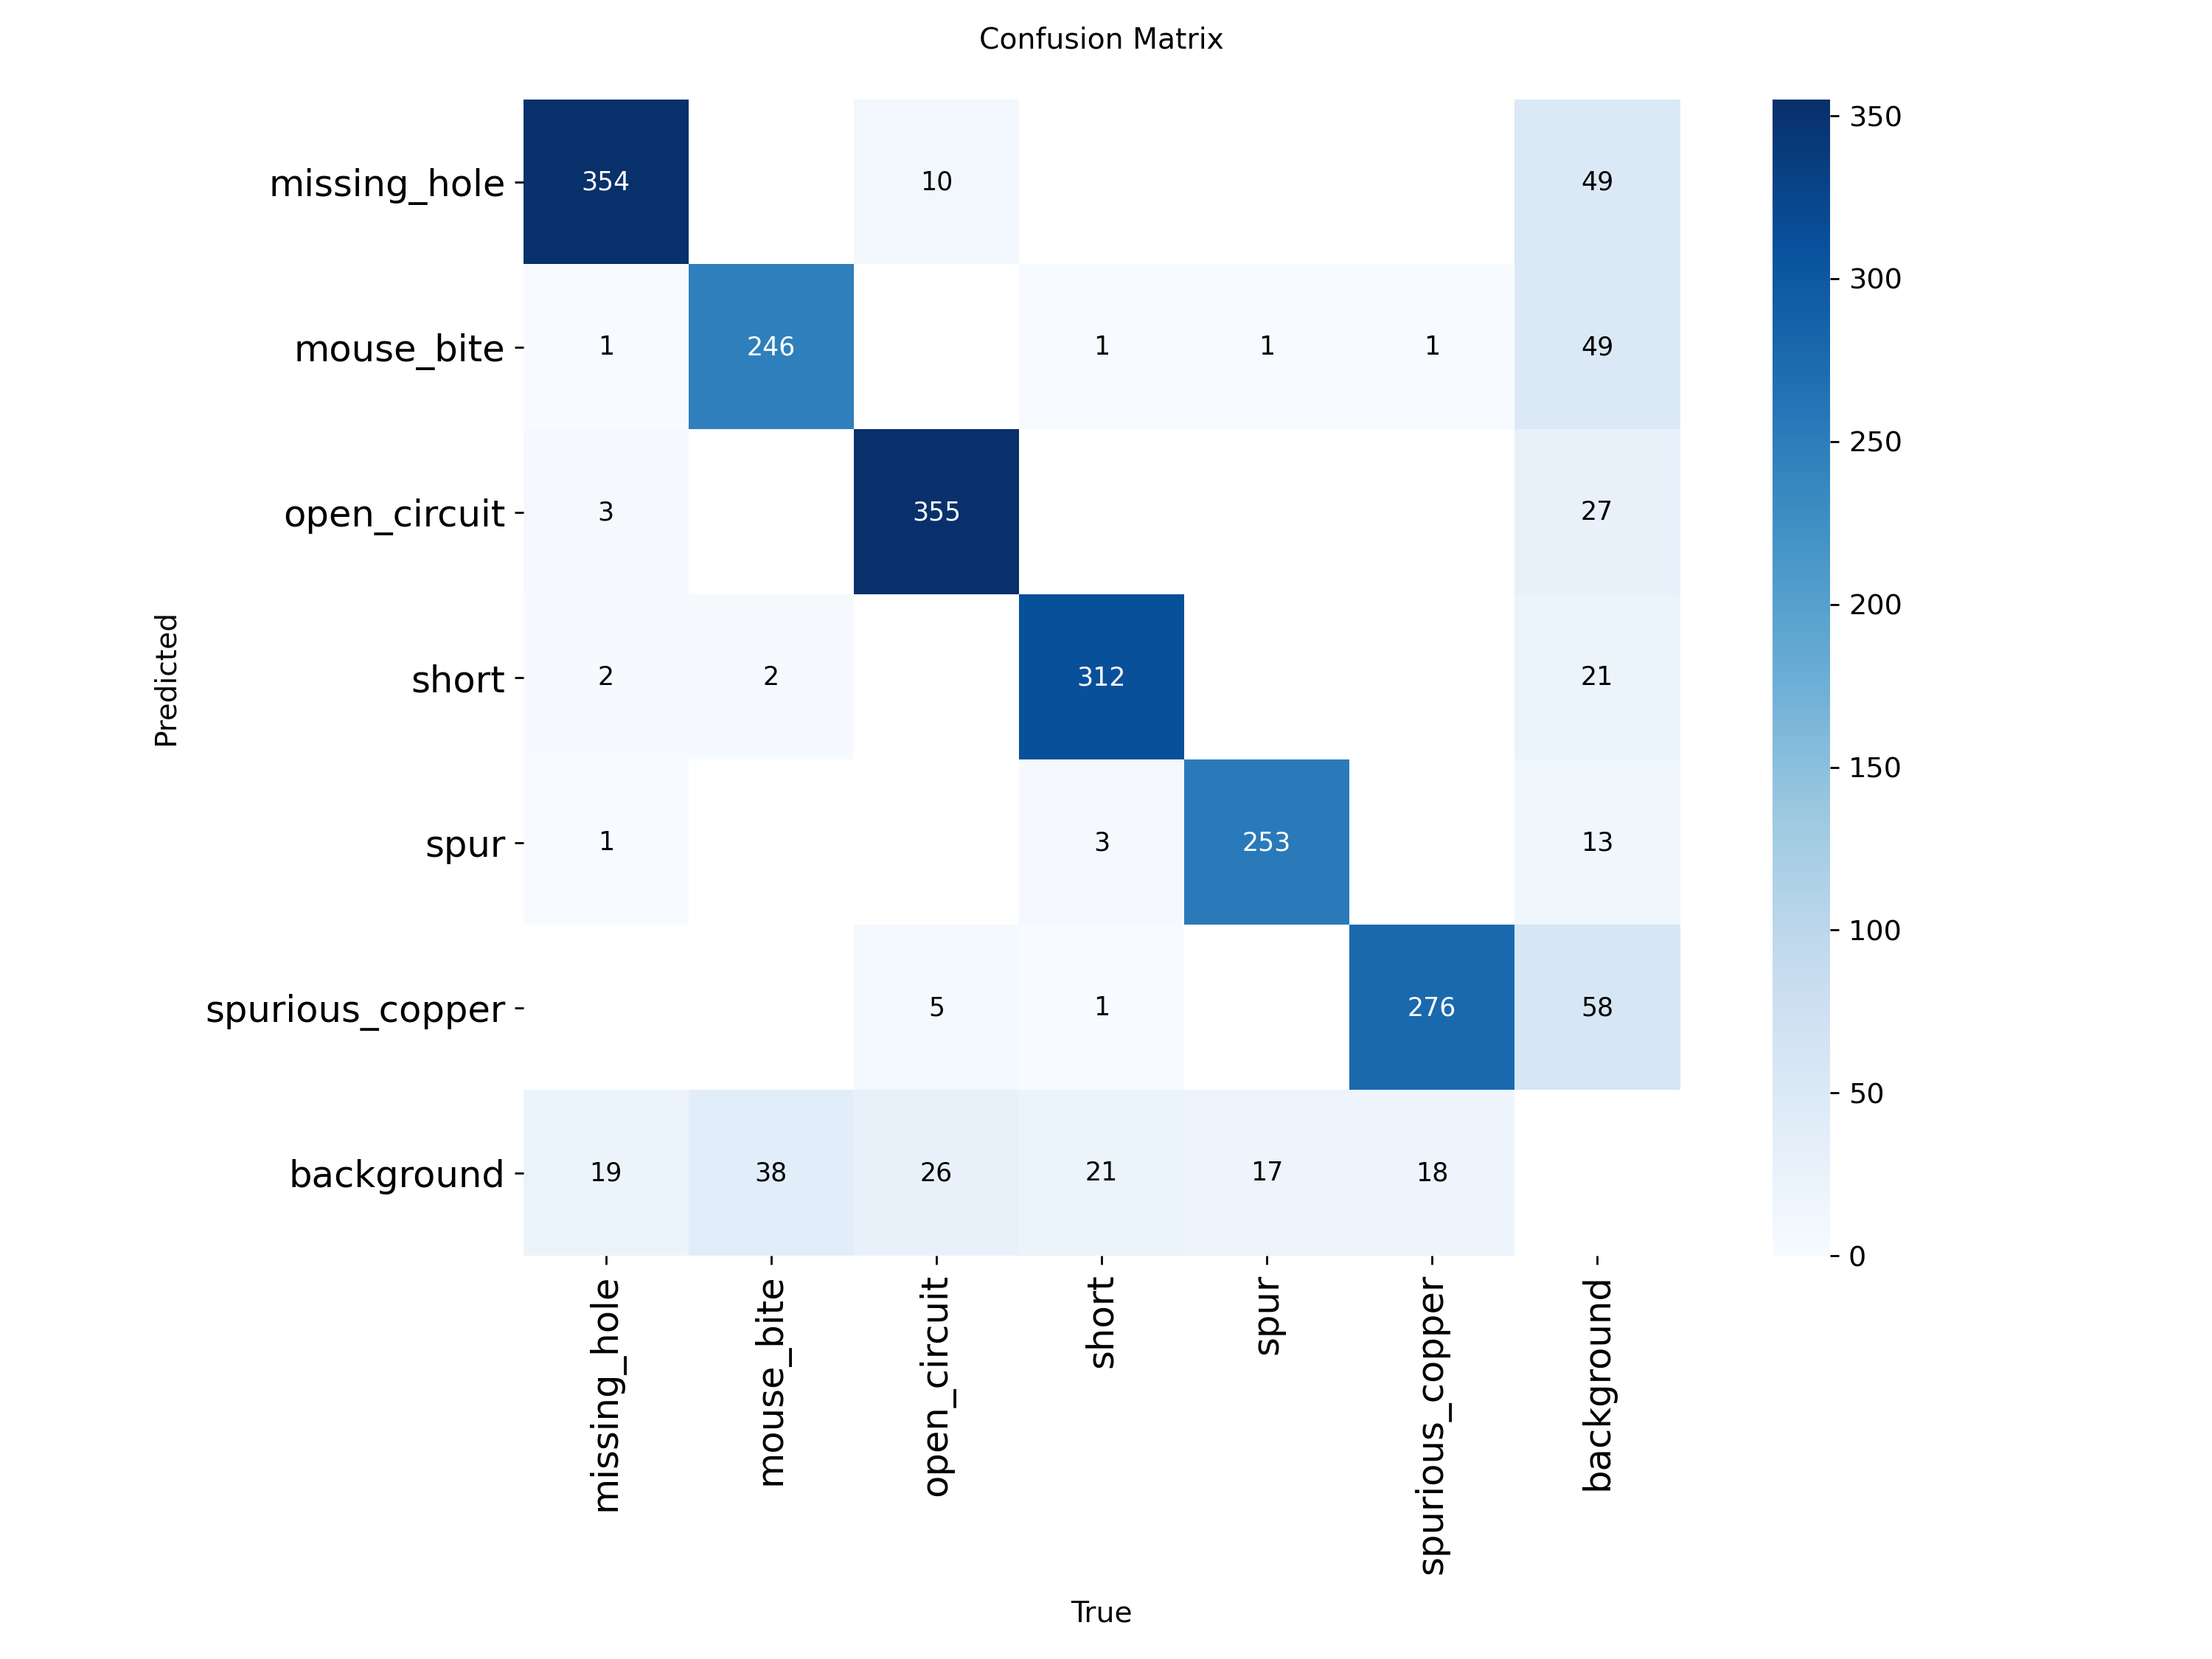

In [15]:
from IPython.display import Image
Image(filename='/kaggle/working/runs/pcb_scratch_model/confusion_matrix.png')

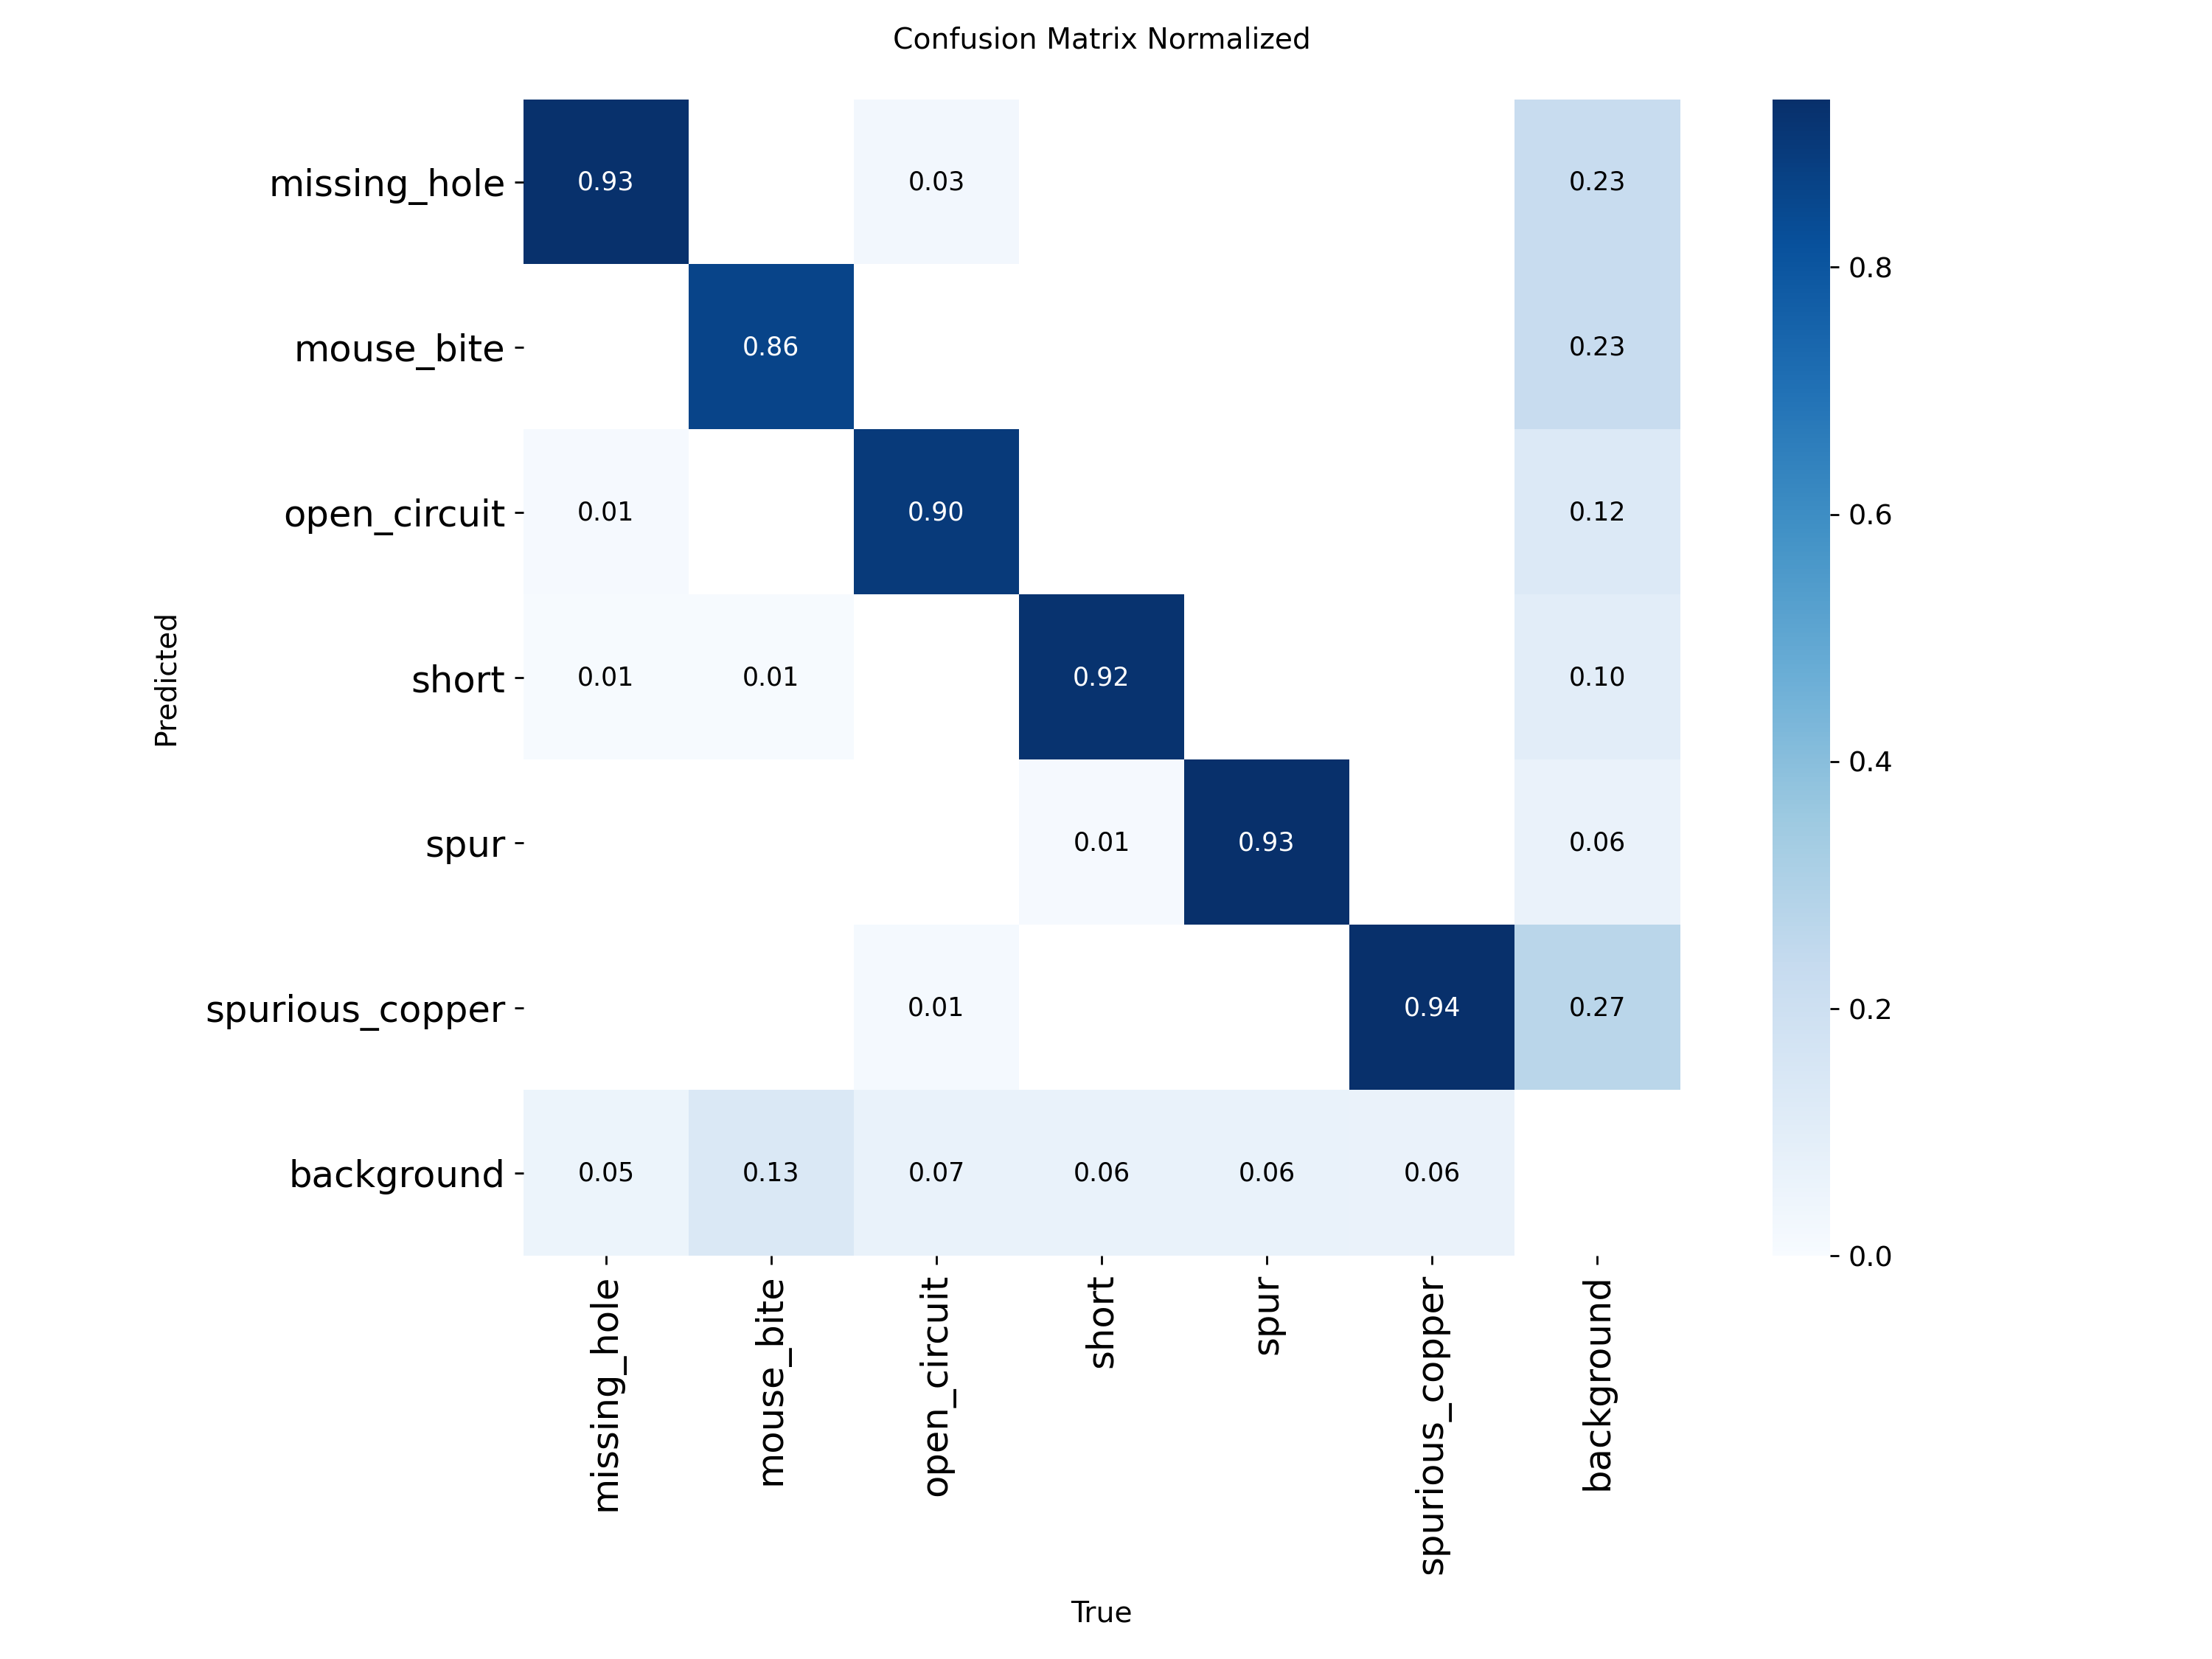

In [16]:
from IPython.display import Image
Image(filename='/kaggle/working/runs/pcb_scratch_model/confusion_matrix_normalized.png')

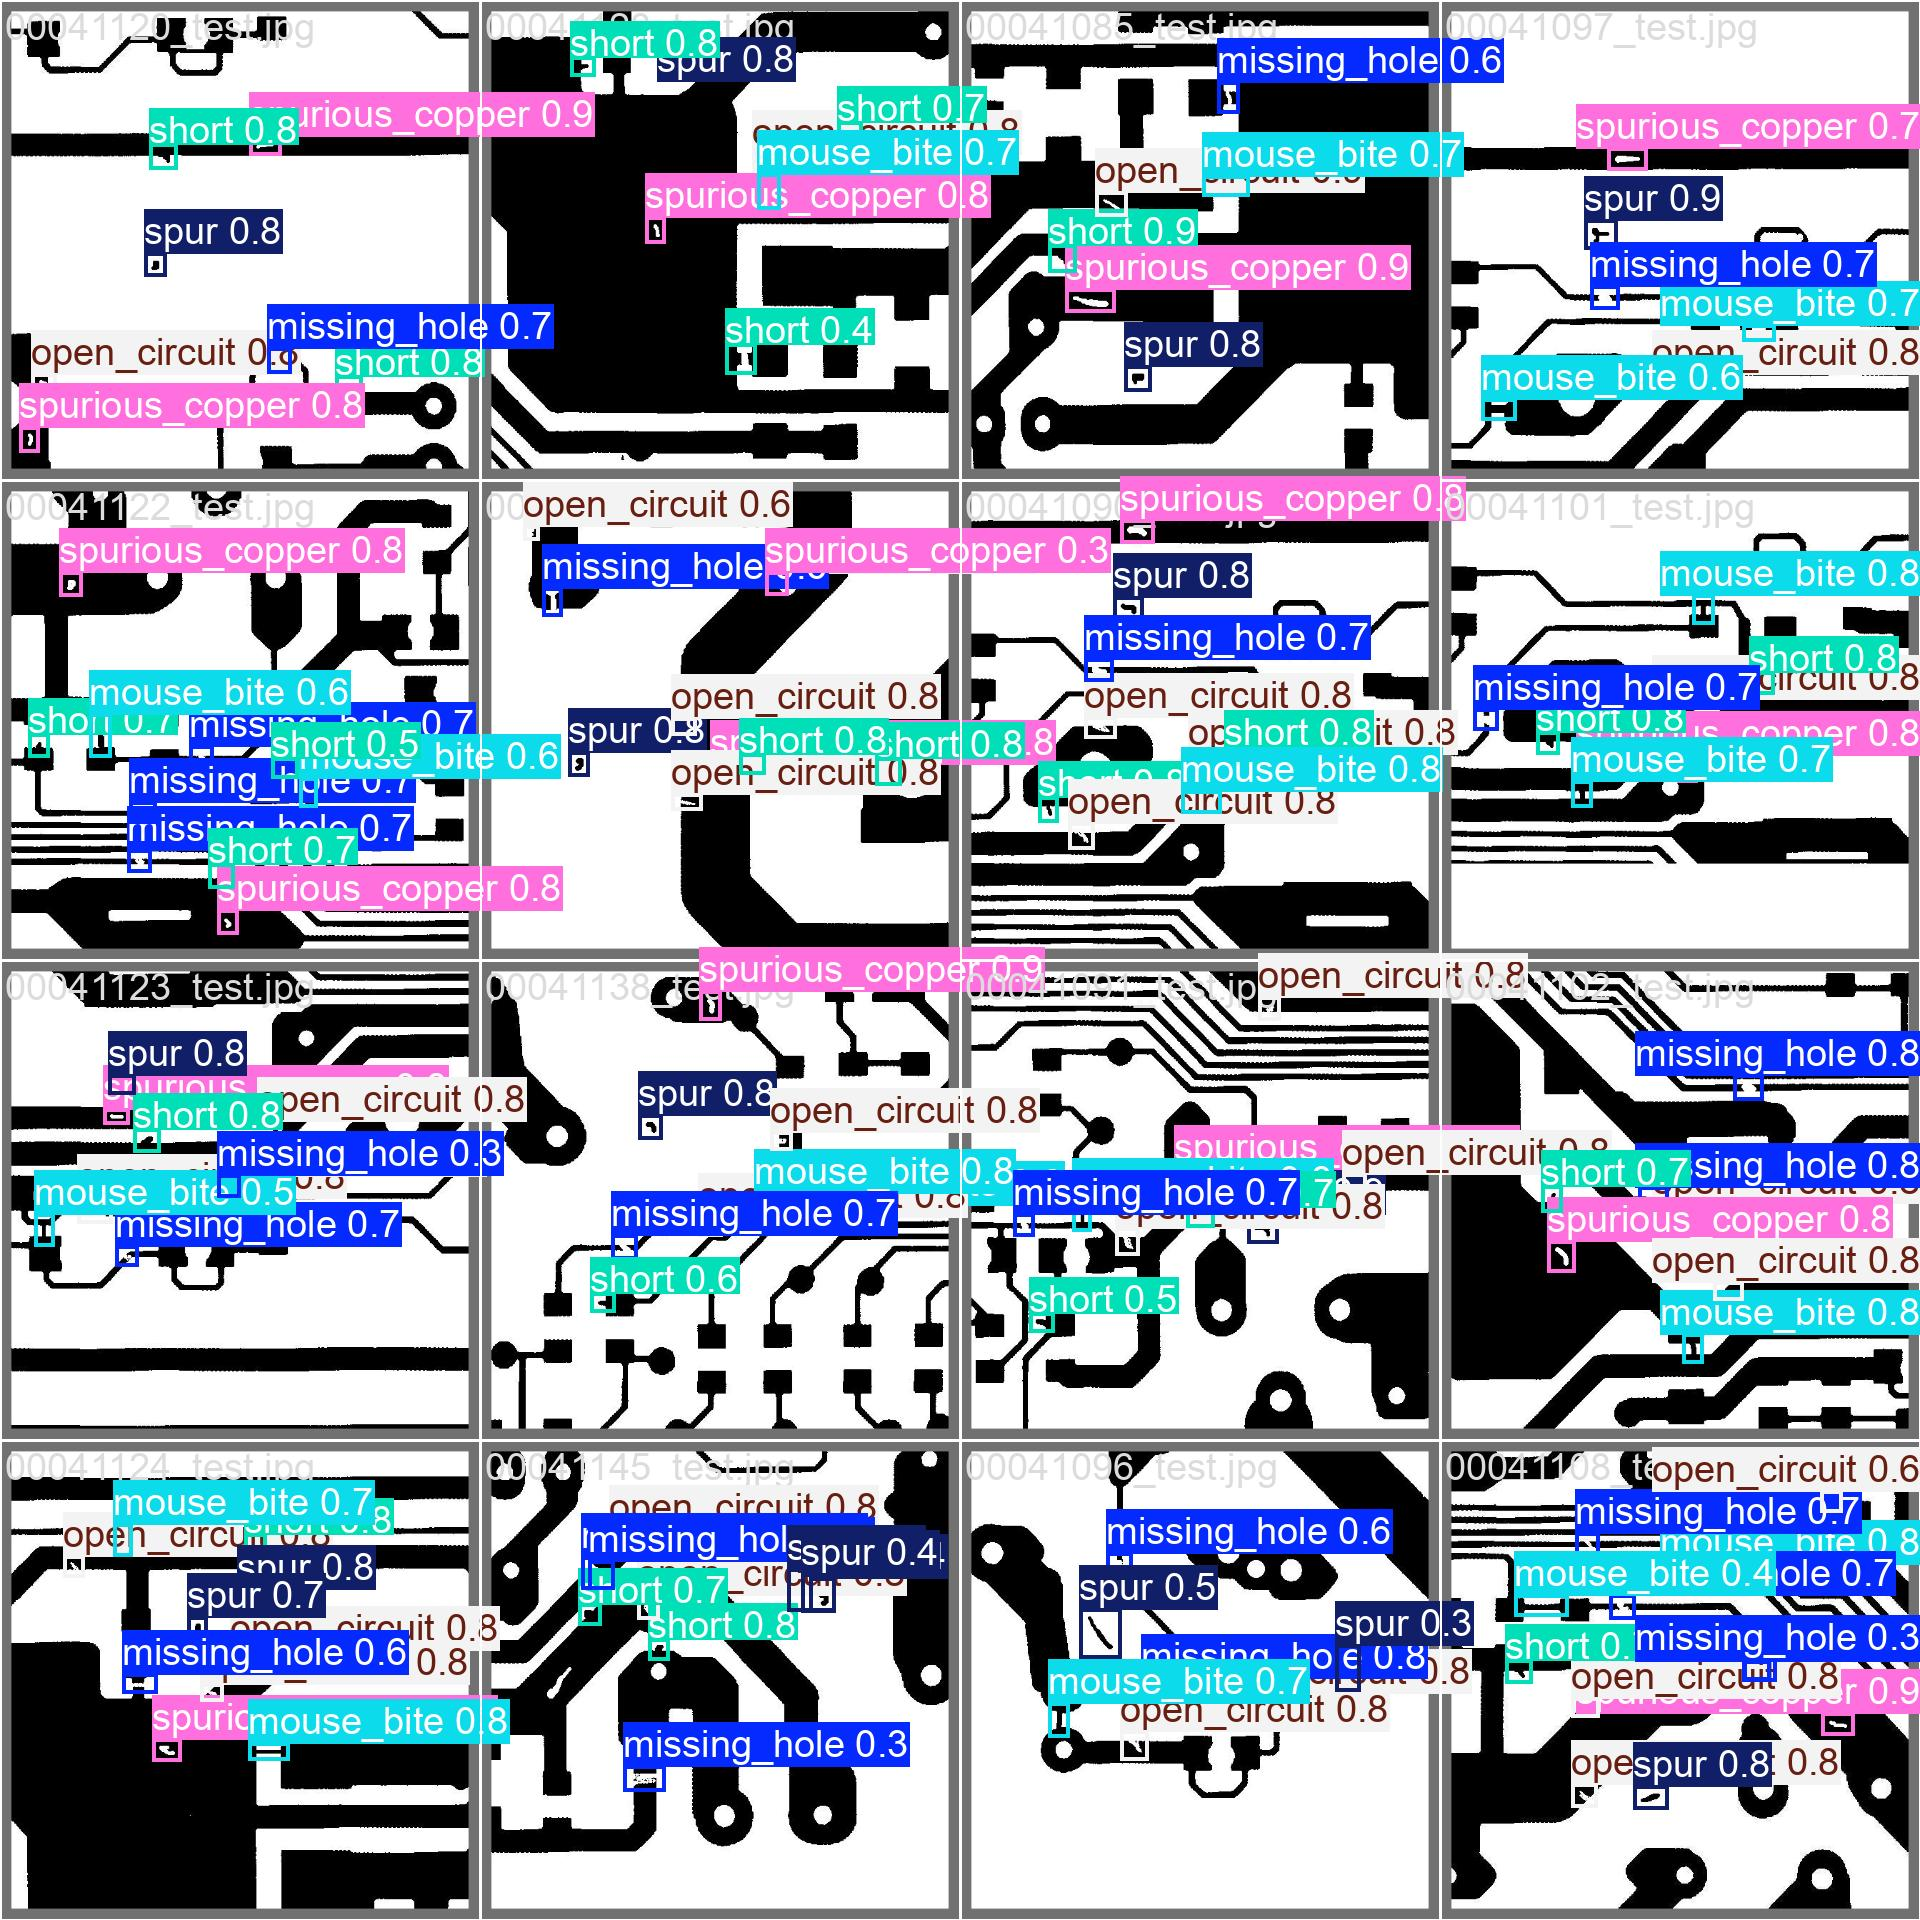

In [17]:
from IPython.display import Image
Image(filename='/kaggle/working/runs/pcb_scratch_model/val_batch1_pred.jpg')

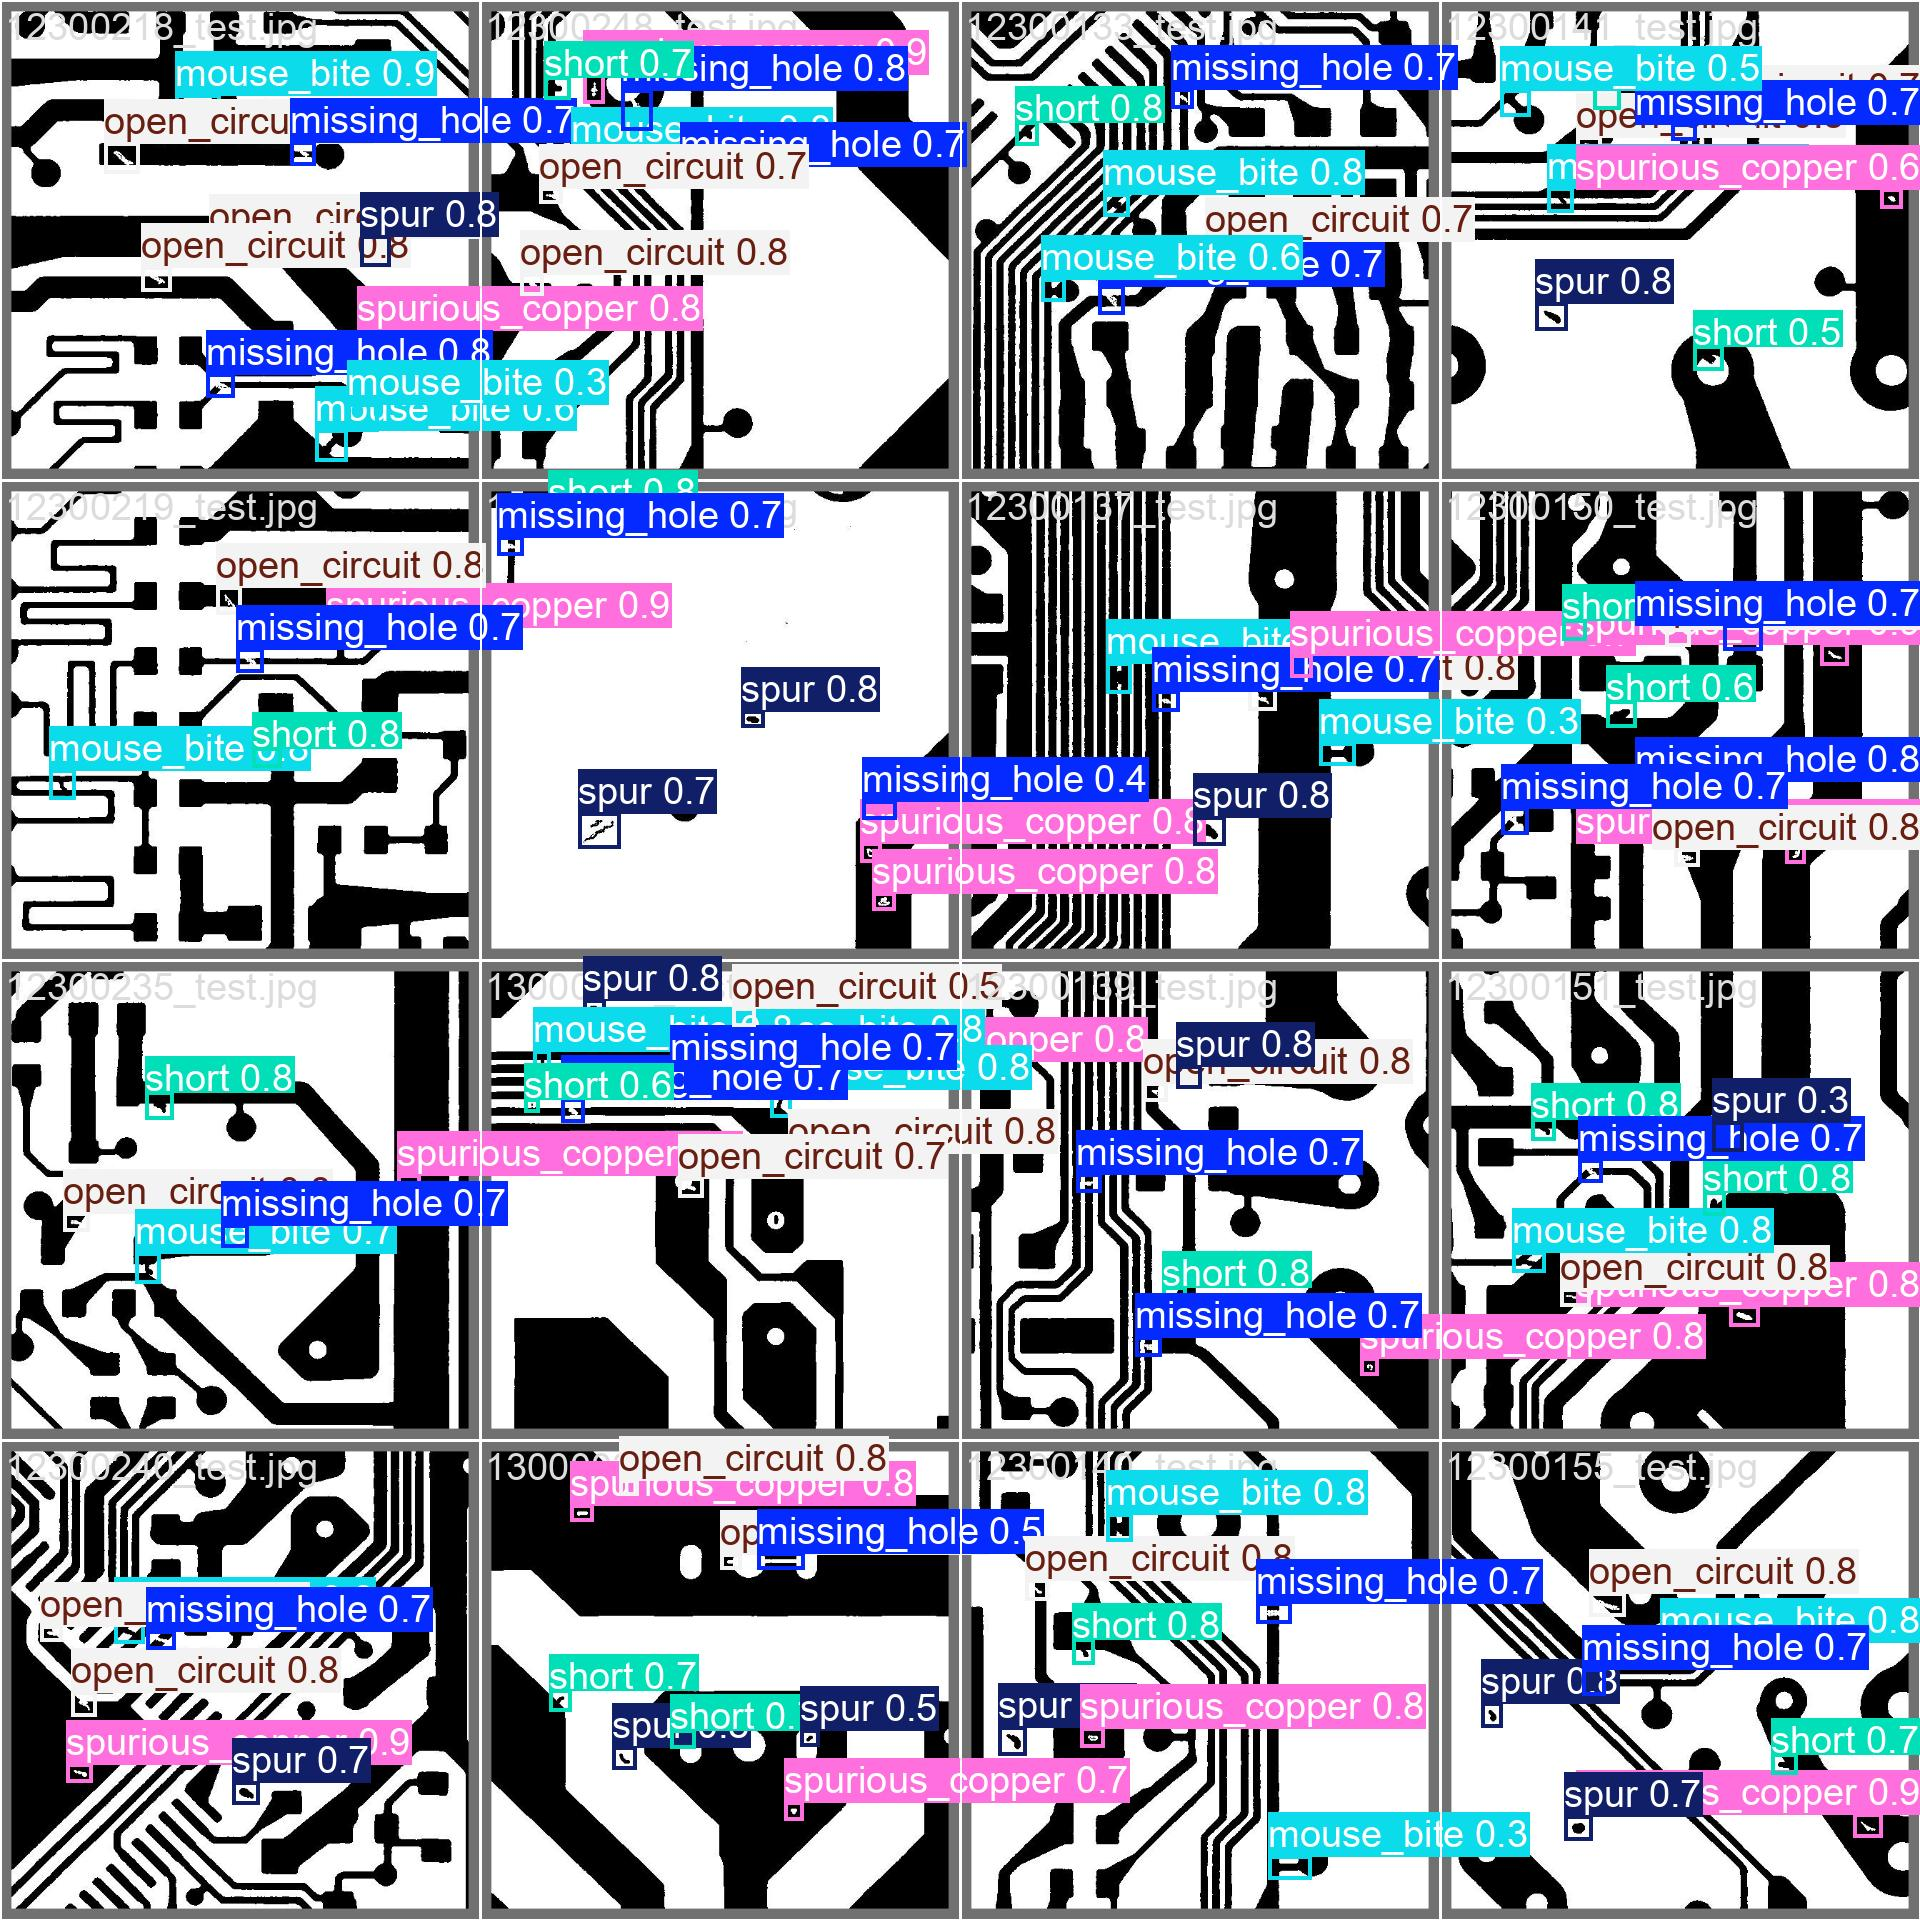

In [18]:
from IPython.display import Image
Image(filename='/kaggle/working/runs/pcb_scratch_model/val_batch2_pred.jpg')


image 1/1 /kaggle/input/deep-pcb/images/val/77000098_test.jpg: 640x640 1 missing_hole, 1 mouse_bite, 2 open_circuits, 1 spur, 1 spurious_copper, 7.3ms
Speed: 1.5ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Image: 77000098_test.jpg
------------------------------------------------------------
DEFECT               | CONF       | CENTER (x,y)    | SEVERITY
------------------------------------------------------------
spurious_copper      | 0.84       | (49, 254)      | HIGH
open_circuit         | 0.82       | (157, 230)      | CRITICAL
missing_hole         | 0.70       | (108, 294)      | CRITICAL
mouse_bite           | 0.57       | (215, 123)      | MODERATE
open_circuit         | 0.54       | (172, 388)      | CRITICAL
spur                 | 0.32       | (104, 293)      | MODERATE


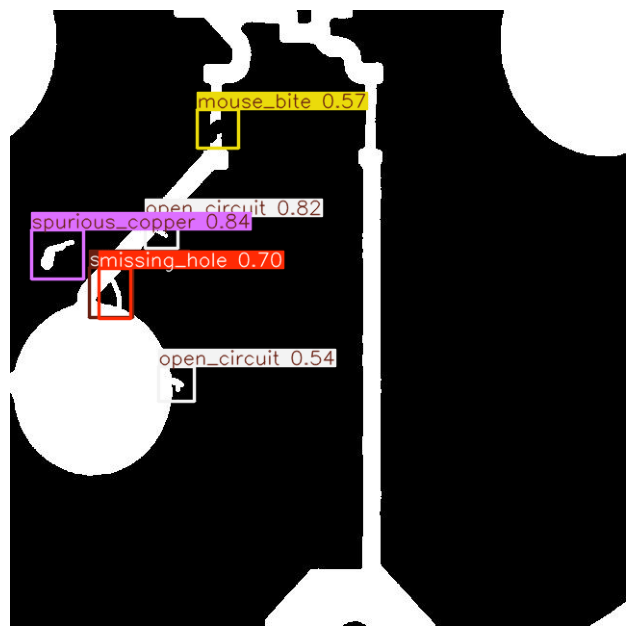

In [25]:
import random
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

def find_images(root_dir):
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
    found_images = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if os.path.splitext(file)[1].lower() in image_extensions:
                found_images.append(os.path.join(root, file))
    return found_images

model_path = '/kaggle/working/runs/pcb_scratch_model/weights/best.pt'
search_path = '/kaggle/input'

all_images = find_images(search_path)
val_images = [img for img in all_images if 'val' in img]

if val_images:
    selected_image = random.choice(val_images)
elif all_images:
    selected_image = random.choice(all_images)
else:
    raise FileNotFoundError("No images found in /kaggle/input")

model = YOLO(model_path)
results = model.predict(selected_image, conf=0.25, save=False)
result = results[0]

img = cv2.imread(selected_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(f"Image: {os.path.basename(selected_image)}")
print("-" * 60)
print(f"{'DEFECT':<20} | {'CONF':<10} | {'CENTER (x,y)':<15} | {'SEVERITY'}")
print("-" * 60)

for box in result.boxes:
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    center_x = int((x1 + x2) / 2)
    center_y = int((y1 + y2) / 2)
    
    cls_id = int(box.cls)
    class_name = result.names[cls_id]
    conf = float(box.conf)
    
    if class_name in ['missing_hole', 'short', 'open_circuit']:
        severity = "CRITICAL"
    elif conf > 0.7:
        severity = "HIGH"
    else:
        severity = "MODERATE"

    print(f"{class_name:<20} | {conf:.2f}       | ({center_x}, {center_y})      | {severity}")

plt.figure(figsize=(12, 8))
plt.imshow(result.plot())
plt.axis('off')
plt.show()


image 1/1 /kaggle/input/deep-pcb/images/val/13000138_test.jpg: 640x640 2 missing_holes, 1 mouse_bite, 1 short, 3 spurs, 7.3ms
Speed: 1.4ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Image: 13000138_test.jpg
------------------------------------------------------------
DEFECT               | CONF       | CENTER (x,y)    | SEVERITY
------------------------------------------------------------
spur                 | 0.77       | (528, 104)      | HIGH
missing_hole         | 0.76       | (414, 497)      | CRITICAL
short                | 0.71       | (96, 480)      | CRITICAL
mouse_bite           | 0.70       | (306, 384)      | MODERATE
missing_hole         | 0.69       | (204, 362)      | CRITICAL
spur                 | 0.67       | (259, 241)      | MODERATE
spur                 | 0.52       | (630, 104)      | MODERATE


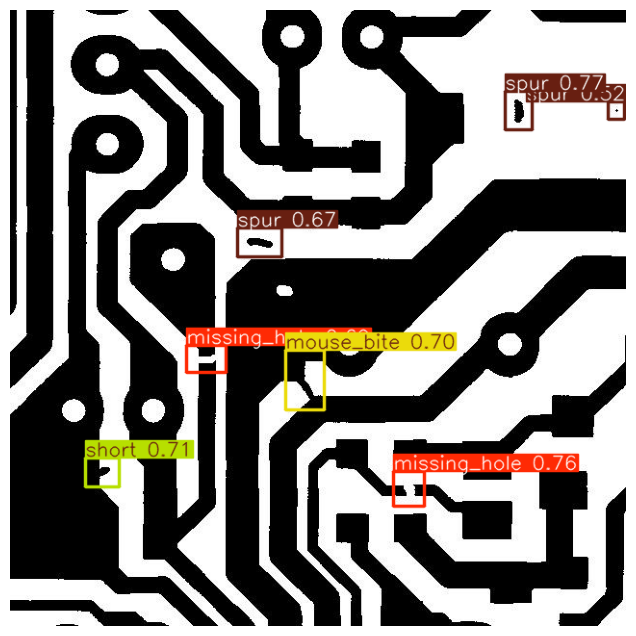

In [26]:
import random
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

def find_images(root_dir):
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
    found_images = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if os.path.splitext(file)[1].lower() in image_extensions:
                found_images.append(os.path.join(root, file))
    return found_images

model_path = '/kaggle/working/runs/pcb_scratch_model/weights/best.pt'
search_path = '/kaggle/input'

all_images = find_images(search_path)
val_images = [img for img in all_images if 'val' in img]

if val_images:
    selected_image = random.choice(val_images)
elif all_images:
    selected_image = random.choice(all_images)
else:
    raise FileNotFoundError("No images found in /kaggle/input")

model = YOLO(model_path)
results = model.predict(selected_image, conf=0.25, save=False)
result = results[0]

img = cv2.imread(selected_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(f"Image: {os.path.basename(selected_image)}")
print("-" * 60)
print(f"{'DEFECT':<20} | {'CONF':<10} | {'CENTER (x,y)':<15} | {'SEVERITY'}")
print("-" * 60)

for box in result.boxes:
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    center_x = int((x1 + x2) / 2)
    center_y = int((y1 + y2) / 2)
    
    cls_id = int(box.cls)
    class_name = result.names[cls_id]
    conf = float(box.conf)
    
    if class_name in ['missing_hole', 'short', 'open_circuit']:
        severity = "CRITICAL"
    elif conf > 0.7:
        severity = "HIGH"
    else:
        severity = "MODERATE"

    print(f"{class_name:<20} | {conf:.2f}       | ({center_x}, {center_y})      | {severity}")

plt.figure(figsize=(12, 8))
plt.imshow(result.plot())
plt.axis('off')
plt.show()


image 1/1 /kaggle/input/deep-pcb/images/val/12300155_test.jpg: 640x640 1 missing_hole, 1 mouse_bite, 1 open_circuit, 1 short, 2 spurs, 1 spurious_copper, 7.3ms
Speed: 1.5ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Image: 12300155_test.jpg
------------------------------------------------------------
DEFECT               | CONF       | CENTER (x,y)    | SEVERITY
------------------------------------------------------------
spurious_copper      | 0.87       | (583, 524)      | HIGH
spur                 | 0.84       | (56, 369)      | HIGH
mouse_bite           | 0.80       | (368, 284)      | HIGH
open_circuit         | 0.79       | (218, 214)      | CRITICAL
short                | 0.75       | (465, 437)      | CRITICAL
spur                 | 0.73       | (177, 527)      | HIGH
missing_hole         | 0.66       | (199, 322)      | CRITICAL


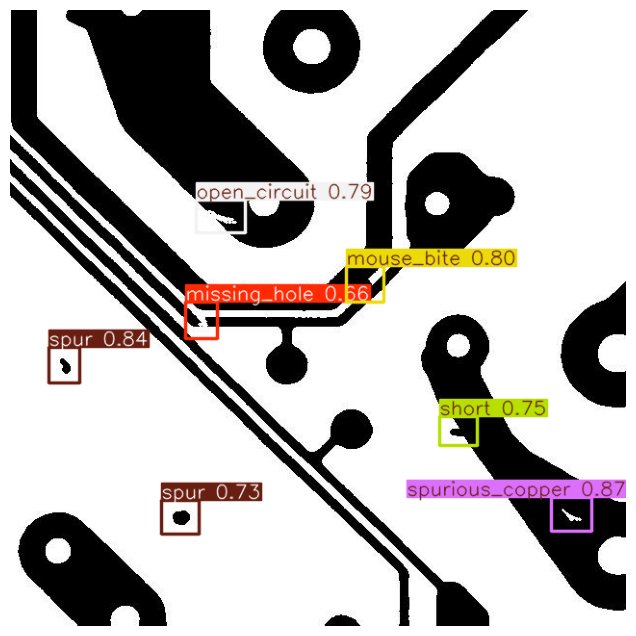

In [27]:
import random
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

def find_images(root_dir):
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
    found_images = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if os.path.splitext(file)[1].lower() in image_extensions:
                found_images.append(os.path.join(root, file))
    return found_images

model_path = '/kaggle/working/runs/pcb_scratch_model/weights/best.pt'
search_path = '/kaggle/input'

all_images = find_images(search_path)
val_images = [img for img in all_images if 'val' in img]

if val_images:
    selected_image = random.choice(val_images)
elif all_images:
    selected_image = random.choice(all_images)
else:
    raise FileNotFoundError("No images found in /kaggle/input")

model = YOLO(model_path)
results = model.predict(selected_image, conf=0.25, save=False)
result = results[0]

img = cv2.imread(selected_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(f"Image: {os.path.basename(selected_image)}")
print("-" * 60)
print(f"{'DEFECT':<20} | {'CONF':<10} | {'CENTER (x,y)':<15} | {'SEVERITY'}")
print("-" * 60)

for box in result.boxes:
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    center_x = int((x1 + x2) / 2)
    center_y = int((y1 + y2) / 2)
    
    cls_id = int(box.cls)
    class_name = result.names[cls_id]
    conf = float(box.conf)
    
    if class_name in ['missing_hole', 'short', 'open_circuit']:
        severity = "CRITICAL"
    elif conf > 0.7:
        severity = "HIGH"
    else:
        severity = "MODERATE"

    print(f"{class_name:<20} | {conf:.2f}       | ({center_x}, {center_y})      | {severity}")

plt.figure(figsize=(12, 8))
plt.imshow(result.plot())
plt.axis('off')
plt.show()


image 1/1 /kaggle/input/deep-pcb/images/val/12300155_test.jpg: 640x640 1 missing_hole, 1 mouse_bite, 1 open_circuit, 1 short, 2 spurs, 1 spurious_copper, 7.3ms
Speed: 1.4ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Image: 12300155_test.jpg
------------------------------------------------------------
DEFECT               | CONF       | CENTER (x,y)    | SEVERITY
------------------------------------------------------------
spurious_copper      | 0.87       | (583, 524)      | HIGH
spur                 | 0.84       | (56, 369)      | HIGH
mouse_bite           | 0.80       | (368, 284)      | HIGH
open_circuit         | 0.79       | (218, 214)      | CRITICAL
short                | 0.75       | (465, 437)      | CRITICAL
spur                 | 0.73       | (177, 527)      | HIGH
missing_hole         | 0.66       | (199, 322)      | CRITICAL


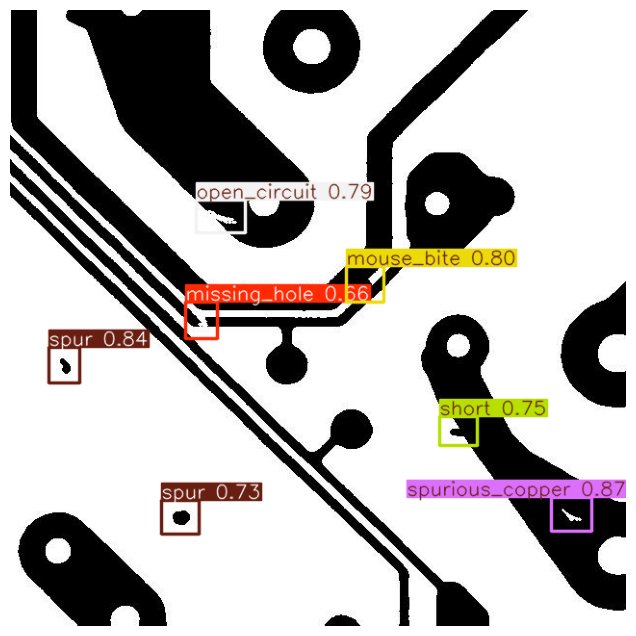

In [29]:
import random
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

def find_images(root_dir):
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
    found_images = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if os.path.splitext(file)[1].lower() in image_extensions:
                found_images.append(os.path.join(root, file))
    return found_images

model_path = '/kaggle/working/runs/pcb_scratch_model/weights/best.pt'
search_path = '/kaggle/input'

all_images = find_images(search_path)
val_images = [img for img in all_images if 'val' in img]

if val_images:
    selected_image = random.choice(val_images)
elif all_images:
    selected_image = random.choice(all_images)
else:
    raise FileNotFoundError("No images found in /kaggle/input")

model = YOLO(model_path)
results = model.predict(selected_image, conf=0.25, save=False)
result = results[0]

img = cv2.imread(selected_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(f"Image: {os.path.basename(selected_image)}")
print("-" * 60)
print(f"{'DEFECT':<20} | {'CONF':<10} | {'CENTER (x,y)':<15} | {'SEVERITY'}")
print("-" * 60)

for box in result.boxes:
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    center_x = int((x1 + x2) / 2)
    center_y = int((y1 + y2) / 2)
    
    cls_id = int(box.cls)
    class_name = result.names[cls_id]
    conf = float(box.conf)
    
    if class_name in ['missing_hole', 'short', 'open_circuit']:
        severity = "CRITICAL"
    elif conf > 0.7:
        severity = "HIGH"
    else:
        severity = "MODERATE"

    print(f"{class_name:<20} | {conf:.2f}       | ({center_x}, {center_y})      | {severity}")

plt.figure(figsize=(12, 8))
plt.imshow(result.plot())
plt.axis('off')
plt.show()